# musicnn_keras example: use it as music feature extractor

### musicnn_keras pre-trained models can be used for transfer learning or as feature extractors

---------------

This notebook explains how to use the `musicnn_keras` model as a music feature extractor. `musicnn_keras` allows you to extract features at every layer of the model. For this reason, we didactically present it so that you can understand what to expect out of each layer. To start, let's consider this music clip:

In [16]:
file_name = 'Outputs\piano_to_slow\Audio_out003.wav'

Run these two lines of code to extract music features with our musicnn model trained with the [MagnaTagATune](https://github.com/keunwoochoi/magnatagatune-list) dataset – the `MTT_musicnn` model:

In [17]:
from musicnn_keras.extractor import extractor
taggram, tags, features = extractor(file_name, model='MTT_musicnn',input_length=3, extract_features=True)


Computing spectrogram (w/ librosa) and tags (w/ tensorflow)..

Out of the extractor, we get the **output** of the model (the `taggram` and its associated `tags`) and all the **intermediate representations** of it (we refer to those as `features`). The `features` are packed in a dictionary:

In [18]:
list(features.keys())

['timbral',
 'temporal',
 'cnn1',
 'cnn2',
 'cnn3',
 'mean_pool',
 'max_pool',
 'penultimate']

These different key-features correspond to the outputs of the different layers that our musicnn model has. For this reason, it is important that you understand the basic bulding blocks of our model – that we briefly outline in the following diagram:

<br>
<img src="./images/musicnn.png" width="650">
<br>

>***Remark:*** *the above key-features (e.g., `timbral`, `cnn3`, or `max_pool`) are yellow-highlighed in the figures below.*

-------------------
The **musically motivated CNN** front-end is the convolutional layer in charge of processing the log-mel spectrogram input. We employ a musically motivated CNN (outlined in the left figure), that consists of a convolutional layer with several filter shapes having different receptive fields that capture musically relevant contexts (these are depicted in the right figure):

<br>
<img src="./images/musicnn-frontend.png" width="950">
<br>

TimbralCNNs employ vertical filters to capture timbral traces. Temporal CNNs employ horizontal filters to capture long and short temporal dependencies in spectrograms. The `timbral` and `temporal` features might contain information associated to these low-level features.

-------------------
The **dense layers** mid-end is in charge of extracting higher-level representations from the low-level features computed by the front-end. It has residual connections that facilitate training, and it has dense connections to allow the back-end to consider information extracted at different hierarchichal levels.

<br>
<img src="./images/musicnn-midend.png" width="600">
<br>

-------------------
The dense **temporal-pooling** back-end part is responsible for predicting tags from the extracted features. And, importantly, it allows for variable-lengths inputs – since the temporal-pooling layers of the back-end would adapt any feature-map length to a fixed feature-map size.

<br>
<img src="./images/musicnn-backend.png" width="600">
<br>

--------------------
### How do front-end features look like?

The output of our front-end is the concatenation of `timbral` and `temporal` features:

In [19]:
import numpy as np
frontend_features = np.concatenate([features['temporal'], features['timbral']], axis=1)

Let's depict how these front-end features look like!

In [20]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

def depict_features(features, coordinates, title, aspect='auto', xlabel=True, fontsize=13):
    # plot features in coordinates
    ax = plt.subplot(coordinates) 
    plt.imshow(features.T, interpolation=None, aspect=aspect)
    # set title
    ax.title.set_text(title + ' (' + str(features.shape[1]) + ')' )
    ax.title.set_fontsize(fontsize)
    # y-axis
    ax.get_yaxis().set_visible(False)
    # x-axis
    x_label = np.arange(0, features.shape[0], features.shape[0]//5)
    ax.set_xticks(x_label)
    ax.set_xticklabels(x_label, fontsize=fontsize)
    if xlabel:
        ax.set_xlabel('(time frames)', fontsize=fontsize)

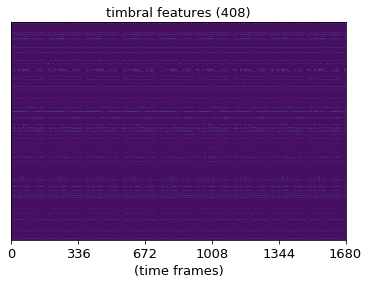

In [21]:
gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(features=features['timbral'],
                coordinates=gs[0, 0],
                title='timbral features',
                aspect='auto')
plt.show()

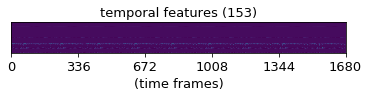

In [22]:
gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 3 cols.
depict_features(features=features['temporal'],
                coordinates=gs[0, 0],
                title='temporal features',
                aspect='equal')
plt.show()

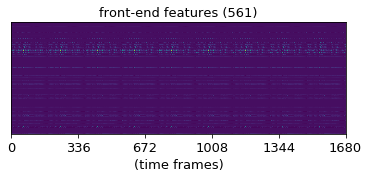

In [23]:
gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 3 cols.
depict_features(features=frontend_features,
                coordinates=gs[0, 0],
                title='front-end features',
                aspect='equal')
plt.show()

The previous figures depict the temporal evolution of the computed features (y-axis: features, x-axis: time).

Remember: the `timbral` features (with 408 features) and the `temporal` features (with 153 features) are concatenated to compose the `front-end` features (with 561 feature maps). These `front-end` features are now fed to mid-end CNN layers.

--------------------
### How do mid-end CNN features look like?

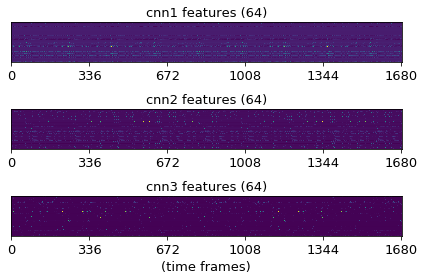

In [24]:
gs = gridspec.GridSpec(3, 1) # create a figure having 1 rows and 3 cols.

depict_features(features=features['cnn1'],
                coordinates=gs[0, 0],
                title='cnn1 features',
                xlabel=False)

depict_features(features=features['cnn2'],
                coordinates=gs[1, 0],
                title='cnn2 features',
                xlabel=False)

depict_features(features=features['cnn3'],
                coordinates=gs[2, 0],
                title='cnn3 features')

plt.tight_layout()
plt.show()

----------------
### How do output features look like?

By default, the model takes inputs of 3 seconds (with no overlap). Out of these 3 sec audio-patches, the model estimates the likelihood of the tags.

Provided that the back-end contains a temporal-pooling layer (mean-pool and max-pool layers), it summarizes all the temporal content into a single value. For that reason, the output features have a temporal resolution of 3 seconds – because out of each 3 seconds input, we compute a tag and its intermediate representations. 

Accordingly, the temporal resolution of the last layers is of 3 seconds – while lower-level features had frame-level temporal resolution.

In [25]:
# plt.rcParams["figure.figsize"] = (9,6)
# gs = gridspec.GridSpec(4, 3) # create a figure having 1 rows and 3 cols.

# depict_features(features=features['mean_pool'],
#                 coordinates=gs[:, 0],
#                 title='mean-pool features')

# depict_features(features=features['max_pool'],
#                 coordinates=gs[:, 1],
#                 title='max-pool features')

# depict_features(features=features['penultimate'],
#                 coordinates=gs[3, 2],
#                 title='penultimate-layer features')

# plt.tight_layout()
# plt.show()

And finally, let's visualize the `taggram` output:

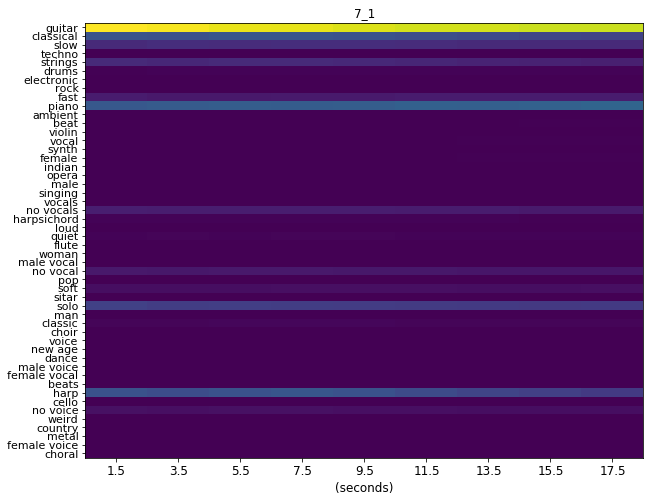

In [31]:
in_length = 3 # seconds -- by default, the model takes inputs of 3 seconds with no overlap
taggram1 = [[x[13] for x in taggram]]

# depict taggram
plt.rcParams["figure.figsize"] = (10,8)
fontsize=12
fig, ax = plt.subplots()
ax.imshow(taggram.T, interpolation=None, aspect="auto")

# title
ax.title.set_text('7_1')
ax.title.set_fontsize(fontsize)

# x-axis title
ax.set_xlabel('(seconds)', fontsize=fontsize)

# y-axis
y_pos = np.arange(len(tags))
ax.set_yticks(y_pos)
ax.set_yticklabels(tags, fontsize=fontsize-1)

# x-axis
x_pos = np.arange(taggram.shape[0])
x_label = np.arange(in_length/2, in_length*taggram.shape[0], 2)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, fontsize=fontsize)

plt.show()

In [29]:
# taggram_out = one_taggram(taggram)

print(taggram[:,13])

[0.00112095 0.00140551 0.0012973  0.00137067 0.00186673 0.00228912
 0.00275502 0.00356367 0.00366229]


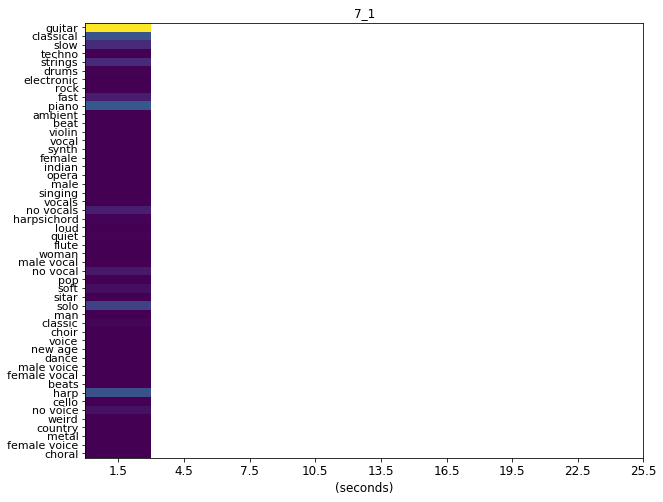

In [30]:
in_length = 3 # seconds -- by default, the model takes inputs of 3 seconds with no overlap

# depict taggram
plt.rcParams["figure.figsize"] = (10,8)
fontsize=12
fig, ax = plt.subplots()
ax.imshow(taggram[:1,:].T, interpolation=None, aspect="auto")

# title
ax.title.set_text('7_1')
ax.title.set_fontsize(fontsize)

# x-axis title
ax.set_xlabel('(seconds)', fontsize=fontsize)

# y-axis
y_pos = np.arange(len(tags))
ax.set_yticks(y_pos)
ax.set_yticklabels(tags, fontsize=fontsize-1)

# x-axis
x_pos = np.arange(taggram[:,13].shape[0])
x_label = np.arange(in_length/2, in_length*taggram[:,13].shape[0], 3)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, fontsize=fontsize)

plt.show()